# Perspektiva - měření výšky v obraze
Cvičení je zaměřené na vyzkoušení si měření výšky objektů v obraze pomocí úběžníků a úběžnic (viz přednáška [Perspektiva a geometrie obrazu](../../../lectures/files/bi-svz-05-perspektiva-obrazu.pdf)). 

Z pohledu zpracování obrazu se jedná o hranovou detekci pomocí [Cannyho detektoru](https://en.wikipedia.org/wiki/Canny_edge_detector) následovanou [Houghovou transformací](https://en.wikipedia.org/wiki/Hough_transform), která nalezené hrany aproximuje přímkami. K zisku úběžníků a úběžnic z nalezených přímek je využit algoritmus [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) převzatý z [githubu](https://github.com/chsasank/Image-Rectification). Ten vyhledá nejvhodnější přímky jdoucí stejným směrem postupně do všech tří úběžníků.

Následně je využit vlastní algoritmus pro odhad výšky objektů `HeightEstimator` na základě měření známých rozměrů v obraze. **Měřit je nutné vždy od spojnice roviny horizontální s rovinou vertikální ve směru osy z.**

Na obrázku příkladu je znázorněno měření dvou referenčních vzdáleností. Dále je na něm znázorněna reálná výška dvou objektů - osob. Měření se zadává vždy v pořadí: bod Tx (top point) a následně bod Bx (bottom point).

![](images/miry.png)

### Import knihoven a konfigurace

In [2]:
import os
import io

import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings

from improutils import *
from skimage import feature, color, transform

warnings.filterwarnings('ignore')
%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

%run height-estimator.ipynb

### Pomocné funkce
Seznam funkcí pro přehlednost:

- [`cv2.cvtColor`](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)


- [`Funkce a modely pro výpočty odhadu výšky`](../svz.ipynb#height_estimation_functions)


- [`show_images`](https://gitlab.fit.cvut.cz/bi-svz/improutils_package/blob/master/improutils/visualisation/visualisation.py#L55)

---

### Úkol
Vytvořte umělou scénu sestávající se ze dvou šachovnic na sebe kolmých. Do scény umístěte objekt, jehož výšku chcete změřit pomocí kamery.

Kamerou získejte obrázek a uložte ho. Následně změřte ručně v obraze dvě a více vzdáleností ve směru osy z (čím více vzdáleností, tím přesnější výsledek). Můžete využít znalosti toho, že jedno pole mřížky má stranu dlouhou 3 cm. Stejné vzdálenosti změřte i v reálné scéně.

Pomocí algoritmu získejte úběžnice a úběžníky. Pomocí nich spočtěte reálnou výšku objektu v obraze.

#### 1) Vytvořte umělou scénu a změřte reálné rozměry v ose z
Umělá scéna by měla vypadat nějak podobně jako na obrázku. 

<img src="images/artificial_scene_chess.png" width="50%">

#### 2) Získejte obrázek umělé scény kamerou Basler a zobrazte
Využijte jakýkoli nástroj, se kterým se již pracovalo (Pylon, [Práce s Basler kamerami notebook](../2/basler-introduction.ipynb)). Dejte pozor na ideální světelné podmínky, zaostření, clonu, expoziční čas, atd!

V případě, že záběr obrázku je větší než samotná scéna, ořízněte si obrázek tak, aby na něm okolí nebylo.

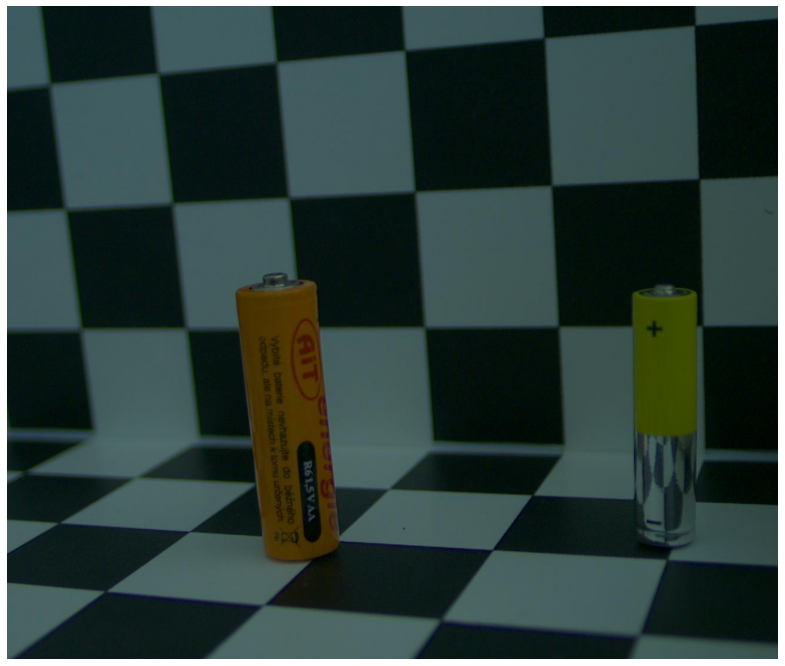

In [96]:
img_bgr = load_image("data/bat.jpg") ###
img_bgr = crop(img_bgr, 400, 0, 1700, 1100)
plot_images(img_bgr)

#### 3) Transformujte obrázek z BGR do RGB a získejte souřadnice úběžníků

vp1 = [-430.1802602709107, 44.11434930044662, 0.08169323944527151]


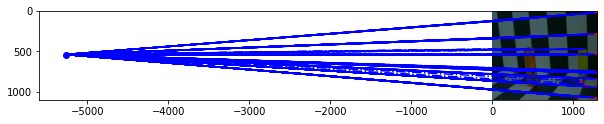

vp2 = [-810.1351170684693, -66.29642195794906, -0.5799483264940831]


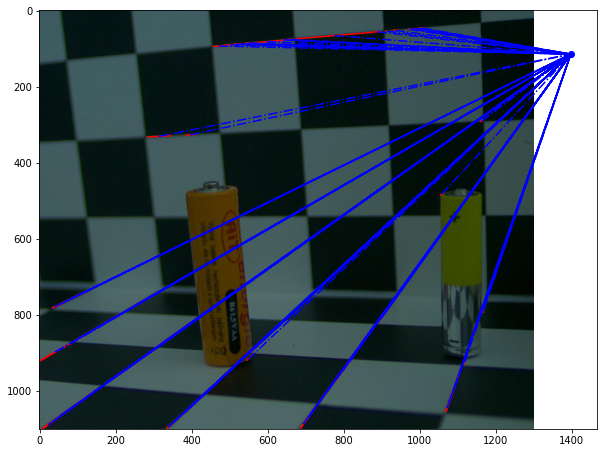

vp3 = [-19.409363985040574, -232.63073378047363, -0.00965892917013543]


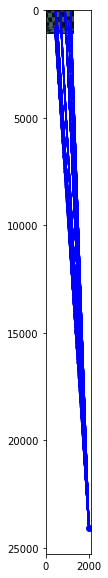

In [97]:
# Funkce compute_vanishing_points vykresluje obrázky pomocí knihovny matplotlib,
# která očekává kanály v pořadí RGB a ne BGR jako OpenCV
img_rgb = img_bgr[:, :, ::-1] ###
vps = compute_vanishing_points(img_rgb)

**POZOR:** Vypočítané úběžníky nemusí nutně být ve správném pořadí! Zkontrolujte, zda `vp1` a `vp2` jsou horizontální úběžníky a `vpz` je úběžník v ose z. V případě, že tomu tak není, zaměňte indexy u `vps` tak, aby tomu tak bylo.

In [98]:
# POZOR! Úběžníky nemusí být ve správném pořadí!
vp1 = vps[0]
vp2 = vps[1]
vpz = vps[2]

#### 4) Zjistěte souřadnice dvojic bodů pro referenční měrení
Vždy se ze dvojice nejdříve volí Tx a následně až Bx. Zvolte celkem 3 dvojice referenčních bodů (ty, pro které máte změřené reálné vzdálenosti) a najděte jejich souřadnice. Referenční body se volí **vždy** v rovině vertikální (viz [úvod](#Perspektiva---měření-výšky-v-obraze)). Následně zvolte 1 dvojici bodů měřených.

In [10]:
show_images(img_bgr)

x = 939, y = 742
x = 927, y = 539
x = 716, y = 734
x = 705, y = 542
x = 324, y = 727
x = 300, y = 547


In [11]:
show_images(img_bgr)

x = 494, y = 933
x = 451, y = 449
x = 1116, y = 910
x = 1108, y = 466


#### 5) Souřadnice doplňte na správná místa skriptu
`REFERENCE_MEASUREMENTS` jsou referenční dvojice bodů a jejich reálná vzdálenost. `Tx` a `Bx` je dvojice bodů měřených.

In [105]:
# Struktura: Tx x,y; Bx x,y; reálná vzdálenost
# např. ((10, 10), (20, 20), 100)
REFERENCE_MEASUREMENTS = [
    ((927, 539), (939, 742), 30), ###
    ((705, 542), (716, 734), 30), ###
    ((300, 547), (324, 727), 30)  ###
]

# Dvojice měřených bodů objektů z obrazu
Bx = (494, 933) ###
Tx = (451, 449) ###

#### 6) Využijte algoritmus pro výpočet odhadu výšky měřeného objektu

In [106]:
# Horizont
vl = np.cross(vp1, vp2)

# Vytvoření objektu pro výpočet odhadu výšky objektu a zavolání funkce
height_estimator = HeightEstimator(REFERENCE_MEASUREMENTS, vl, vpz)
height = abs(height_estimator.calc_height(Tx, Bx))

# Výstup
print('Objekt {:.2f} mm'.format(height))

Objekt 55.65 mm


---
#### 7*) Dobrovolná úloha za 1 bod aktivity
Upravte výše uvedené tak, abyste vypočítali výšku lidí z obrazu `test.jpg`. Pro kontrolu je reálná výška zobrazena na obrázku výše.

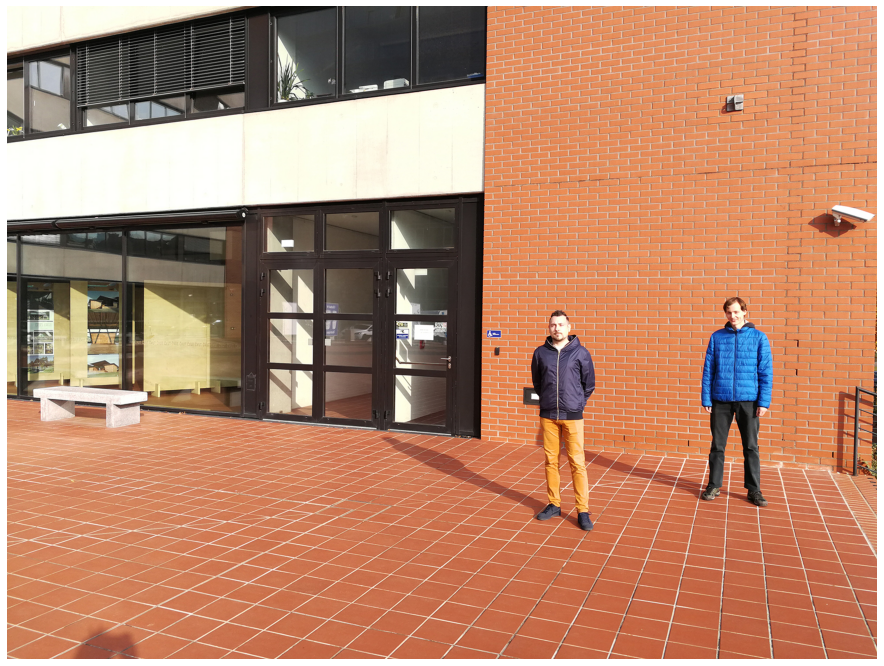

In [126]:
img_bgr = load_image('data/test.jpg') ###
# img_bgr = crop(img, 0, 347, 1516, 1182)
plot_images(img_bgr)

vp1 = [-445.1158247149197, 62.8823766458496, 0.13270698757944915]


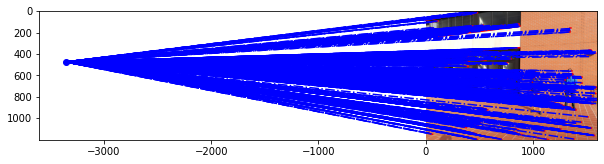

vp2 = [24.34713061596313, 1361.8430688987967, 0.017541160386140585]


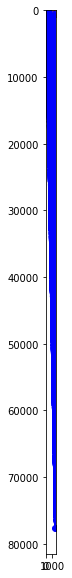

vp3 = [672.5564470778017, 287.5506635440653, 0.4956305143328221]


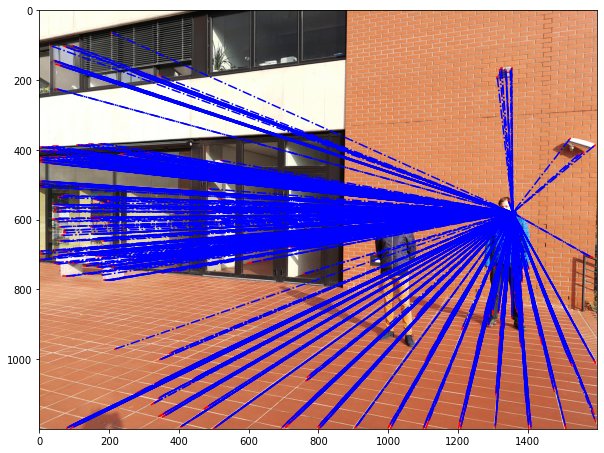

In [127]:
img_rgb = img_bgr[:, :, ::-1] ###
vps = compute_vanishing_points(img_rgb)



In [128]:
# POZOR! Úběžníky nemusí být ve správném pořadí!
vp1 = vps[0]
vp2 = vps[2]
vpz = vps[1]

In [ ]:
show_images(img_bgr)

In [146]:
# Struktura: Tx x,y; Bx x,y; reálná vzdálenost
# např. ((10, 10), (20, 20), 100)
REFERENCE_MEASUREMENTS = [
    ((886, 611),(881, 801), 139), ###
    ((906, 799),(909, 595),  149), ###
]

# Dvojice měřených bodů objektů z obrazu
Bx0 = (1027, 965) ###
Tx0 = (1016, 510) ###
Bx1 = (1337, 912) ###
Tx1 = (1342, 495) ###


In [147]:
# Horizont
vl = np.cross(vp1, vp2)

# Vytvoření objektu pro výpočet odhadu výšky objektu a zavolání funkce
height_estimator = HeightEstimator(REFERENCE_MEASUREMENTS, vl, vpz)
height = abs(height_estimator.calc_height(Tx0, Bx0))

# Výstup
print('Objekt {:.2f} cm'.format(height))

Objekt 170.71 cm


In [148]:
# Horizont
vl = np.cross(vp1, vp2)

# Vytvoření objektu pro výpočet odhadu výšky objektu a zavolání funkce
height_estimator = HeightEstimator(REFERENCE_MEASUREMENTS, vl, vpz)
height = abs(height_estimator.calc_height(Tx1, Bx1))

# Výstup
print('Objekt {:.2f} cm'.format(height))

Objekt 187.34 cm
